<a href="https://colab.research.google.com/github/Kennedy87670/Introduction-to-ML-DP/blob/main/06_Pytorch_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## What is transfer learning?
Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a language model (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.0+cu116
0.14.0+cu116


## Now lets import

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3383, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 3383 (delta 33), reused 49 (delta 22), pack-reused 3302
Receiving objects: 100% (3383/3383), 641.74 MiB | 41.29 MiB/s, done.
Resolving deltas: 100% (1940/1940), done.
Checking out files: 100% (221/221), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data

we need the data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and Dataloaders

Now we have got some data, want to turn it into Pytorch Dataloaders.

1. Manaually create transforms- you define what transforms you want your data to go through 
2. Automatically created transforms - the tranforms for your data are defined by the model you like to use

Important point: when using a pretrained model, its important that the data (including your custom data) that you pass through it is **transformed** in the same way the data the model was trained on 

## 2.1 Creating a transform for `torchvision.models` (manual creation)

torchvisions.models contains pretrained models (models ready for tranfer learning) with torchvision

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [6]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [7]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7faf4809bbe0>,
 ['pizza', 'steak', 'sushi'])

## Creating a transform automatically .torchvision.models

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# get the transorms used to craete our pretarined weights
auto_transformer = weights.transforms()
auto_transformer

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transformer, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7faf48086430>,
 ['pizza', 'steak', 'sushi'])

### 3. Getting a pretrains model
1. pytorch domain library
2. libraries like timm (torch image models)
3. HuggingFaceHub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)


## 3.1 which pretrained model should i use?

experiment, experiment, experiment

Things to consider
1. speed -  how fast does it run?
2. Size - how big is the model?
3. performance- how well does it go on your chosen problem

## 3.2 Setting up a pretrained model

In [11]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

## 3.3 Getting a summary of our model with torchinfo.summary()

In [12]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## 3.4 Freezing the base model and changing the output layer to suit our needs

In [13]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [15]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train our model

In [17]:
# DEFINE LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Import train function
from going_modular.going_modular import engine

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5770 | train_acc: 0.8984 | test_loss: 0.5715 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5259 | train_acc: 0.9141 | test_loss: 0.5457 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5250 | train_acc: 0.8047 | test_loss: 0.5300 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8125 | test_loss: 0.5080 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8164 | test_loss: 0.4390 | test_acc: 0.9062
[INFO] Total training time: 26.925 seconds


## Evalaute model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


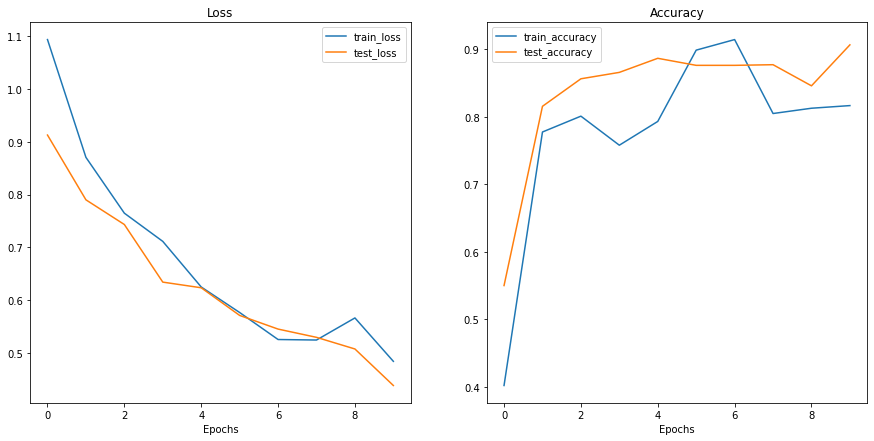

In [19]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. make predictions on images from the test set

we must make sure its:
* same- shape =  images need to be in the same shape
* Same dataype - custom data  should be in the same data type
* same device - custom data/test data should be on the same device as the model
* same transform - if you have transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this lets create a function

To do all of this, we'll create a function pred_and_plot_image() to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with PIL.Image.open().
3. Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from weights.transforms()).
4. Make sure the model is on the target device.
5. Turn on model eval mode with model.eval() (this turns off layers like nn.Dropout(), so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with torch.unsqueeze(dim=0) so our input image has shape [batch_size, color_channels, height, width].
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with torch.softmax().
9. Convert model's prediction probabilities to prediction labels with torch.argmax().
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8.

In [ ]:
from typing import List, Tuple

from PIL import Image
from torch vision import transforms

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);